In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np
from scipy import stats
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# This will ignore the specific ConvergenceWarning from statsmodels
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')

#  1. Load, Prepare and Visualize the Data 

In [6]:
# Load the CSV file
df = pd.read_csv('../../data/explorations/slice_model_prompt_analysis.csv', index_col=0)

# Reshape the data from wide to long format
df_long = pd.melt(df, id_vars=['models', 'prompts'], 
                  var_name='slice', value_name='correlation')

# Convert the 'slice' column to a numeric type for modeling
df_long['slice'] = pd.to_numeric(df_long['slice'])

# Rename columns for easier use in formulas
df_long.rename(columns={'models': 'model', 'prompts': 'prompt'}, inplace=True)

df_long


,model,prompt,slice,correlation
0,GPT,Prompt#1,0.01,0.323791
1,GPT,Prompt#2,0.01,0.260493
2,GPT,Prompt#3,0.01,0.331306
3,GPT,Prompt#4,0.01,0.253020
4,GPT,Prompt#5,0.01,0.098524
...,...,...,...,...
75,Gemini,Prompt#1,0.75,0.740960
76,Gemini,Prompt#2,0.75,0.795146
77,Gemini,Prompt#3,0.75,0.775638
78,Gemini,Prompt#4,0.75,0.642218


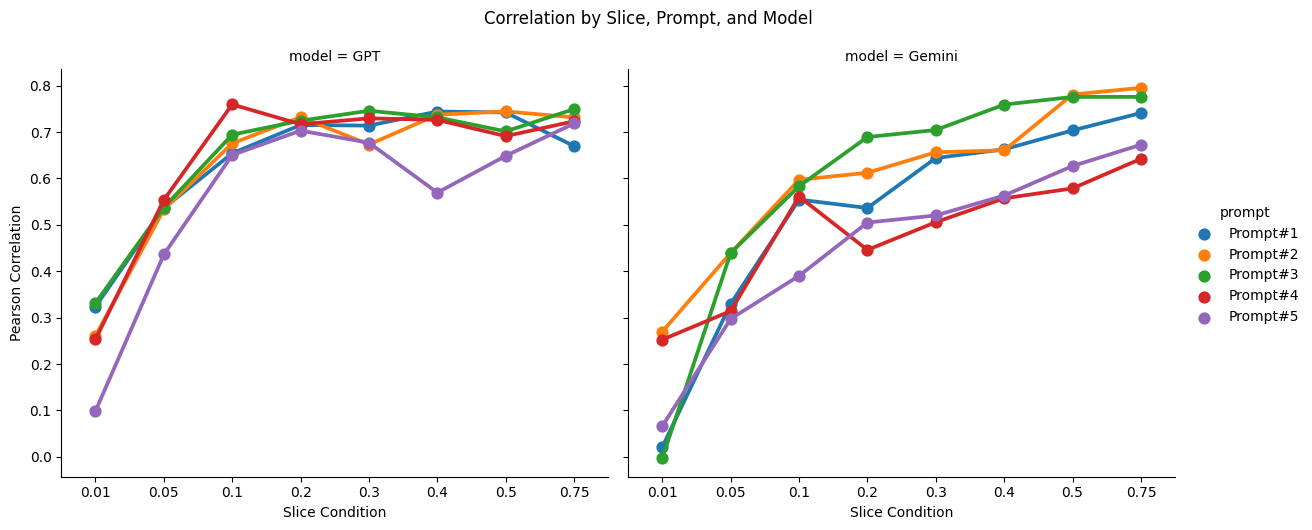

In [7]:
# --- 3. Visualization --
g = sns.catplot(
    data=df_long,
    x='slice',
    y='correlation',
    hue='prompt',
    col='model',
    kind='point',
    height=5,
    aspect=1.2
)
g.fig.suptitle('Correlation by Slice, Prompt, and Model', y=1.05)
g.set_axis_labels('Slice Condition', 'Pearson Correlation')
plt.show()

# Pairwise comparisons and bonferroni approach

In [8]:
# Define the sample size underyling the correlations
N = 128

# --- 2. Function for Fisher's z-transformation test ---
def compare_correlations(r1, r2, n):
    """Compares two Pearson correlations using Fisher's z-transformation."""
    # Fisher's z-transformation
    z1 = 0.5 * np.log((1 + r1) / (1 - r1))
    z2 = 0.5 * np.log((1 + r2) / (1 - r2))
    
    # Standard error of the difference
    se_diff = np.sqrt(1 / (n - 3) + 1 / (n - 3))
    
    # Z-score for the difference
    z_score = (z1 - z2) / se_diff
    
    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    
    return p_value

# ---  Perform All Pairwise Comparisons ---
results = []
# Iterate through each unique model and slice
for model_name in df_long['model'].unique():
    for slice_val in df_long['slice'].unique():
        
        # Get the data for this specific condition
        condition_df = df_long[(df_long['model'] == model_name) & (df_long['slice'] == slice_val)]
        
        # Get all pairwise combinations of prompts
        prompt_pairs = itertools.combinations(condition_df['prompt'].unique(), 2)
        
        for p1, p2 in prompt_pairs:
            r1 = condition_df[condition_df['prompt'] == p1]['correlation'].iloc[0]
            r2 = condition_df[condition_df['prompt'] == p2]['correlation'].iloc[0]
            
            p_value_uncorrected = compare_correlations(r1, r2, N)
            
            results.append({
                'model': model_name,
                'slice': slice_val,
                'prompt_1': p1,
                'prompt_2': p2,
                'r1': r1,
                'r2': r2,
                'p_value_uncorrected': p_value_uncorrected
            })

results_df = pd.DataFrame(results)

results_df

,model,slice,prompt_1,prompt_2,r1,r2,p_value_uncorrected
0,GPT,0.01,Prompt#1,Prompt#2,0.323791,0.260493,0.584119
1,GPT,0.01,Prompt#1,Prompt#3,0.323791,0.331306,0.946938
2,GPT,0.01,Prompt#1,Prompt#4,0.323791,0.253020,0.541447
3,GPT,0.01,Prompt#1,Prompt#5,0.323791,0.098524,0.060945
4,GPT,0.01,Prompt#2,Prompt#3,0.260493,0.331306,0.539262
...,...,...,...,...,...,...,...
155,Gemini,0.75,Prompt#2,Prompt#4,0.795146,0.642218,0.010583
156,Gemini,0.75,Prompt#2,Prompt#5,0.795146,0.672550,0.032871
157,Gemini,0.75,Prompt#3,Prompt#4,0.775638,0.642218,0.031286
158,Gemini,0.75,Prompt#3,Prompt#5,0.775638,0.672550,0.083471


In [9]:
# --- 4. Apply Bonferroni Correction ---
num_tests = len(results_df)
results_df['p_value_corrected'] = results_df['p_value_uncorrected'] * num_tests
# Cap corrected p-values at 1.0
results_df['p_value_corrected'] = results_df['p_value_corrected'].clip(upper=1.0)

# --- 5. Report Significant Findings ---
significant_results = results_df[results_df['p_value_corrected'] < 0.05].sort_values('p_value_corrected')

print("--- Analysis 1: Pairwise Comparisons ---")
print(f"Total number of comparisons performed: {num_tests}")
print(f"Significance threshold (alpha) after Bonferroni correction: {0.05 / num_tests:.5f}\n")

if significant_results.empty:
    print("RESULT: After applying a strict Bonferroni correction, NO pairwise comparisons between prompts were statistically significant.")
else:
    print("RESULT: The following pairwise comparisons remained significant after Bonferroni correction:")
    print(significant_results)

--- Analysis 1: Pairwise Comparisons ---
Total number of comparisons performed: 160
Significance threshold (alpha) after Bonferroni correction: 0.00031

RESULT: After applying a strict Bonferroni correction, NO pairwise comparisons between prompts were statistically significant.


# Mixed Effects

In [10]:

# modeling a random intercept AND a random slope for `slice` across prompts.
# This directly tests if the relationship with 'slice' differs for each prompt.
# - Fixed Effects: correlation ~ slice * C(model)
# - Random Effects: A random intercept and random slope for 'slice' grouped by 'prompt'.
#   This is specified via re_formula="~slice"
print("---  Mixed-Effects Model Results (with Random Slopes) ---")

# The `re_formula="~slice"` is shorthand for "~ 1 + slice", modeling both a
# random intercept and a random slope for slice.
model_advanced = mixedlm("correlation ~ slice * C(model)", 
                         df_long, 
                         groups=df_long["prompt"], 
                         re_formula="~slice")

result_advanced = model_advanced.fit()
print(result_advanced.summary())



---  Mixed-Effects Model Results (with Random Slopes) ---
               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    correlation
No. Observations:     80         Method:                REML       
No. Groups:           5          Scale:                 0.0177     
Min. group size:      16         Log-Likelihood:        39.6746    
Max. group size:      16         Converged:             Yes        
Mean group size:      16.0                                         
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.511    0.036 14.020 0.000  0.440  0.583
C(model)[T.Gemini]       -0.166    0.047 -3.539 0.000 -0.258 -0.074
slice                     0.398    0.089  4.479 0.000  0.224  0.573
slice:C(model)[T.Gemini]  0.243    0.126  1.936 0.053 -0.003  0.490
Group

### Variance Components

In [11]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import mixedlm


# --- 2. Run the Advanced Mixed-Effects Model ---
# This is the same model as before, with random intercepts and slopes for prompts.
model_advanced = mixedlm("correlation ~ slice * C(model)", 
                         df_long, 
                         groups=df_long["prompt"], 
                         re_formula="~slice")
result_advanced = model_advanced.fit()


# --- 3. Calculate Nakagawa & Schielzeth's R-squared ---
def calculate_r2_mixed(model_result, data_long):
    """Calculates Nakagawa & Schielzeth's R-squared for a mixed-effects model."""
    
    # Variance of the fixed effects
    # This is the variance of the predicted values from the fixed effects alone
    var_fixed = np.var(model_result.predict(data_long))
    
    # Variance of the random effects
    # Sum of the variances of the random intercept and random slope
    random_effects_variances = np.diag(model_result.cov_re)
    var_random = np.sum(random_effects_variances)

    # Variance of the residuals
    var_residual = model_result.scale
    
    # Marginal R-squared (variance explained by fixed effects)
    r2_marginal = var_fixed / (var_fixed + var_random + var_residual)
    
    # Conditional R-squared (variance explained by fixed and random effects)
    r2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_residual)
    
    return r2_marginal, r2_conditional

r2_marginal, r2_conditional = calculate_r2_mixed(result_advanced, df_long)

# Get individual variance components for detailed reporting
random_effects_variances = np.diag(result_advanced.cov_re)
var_intercept = random_effects_variances[0]
var_slope = random_effects_variances[1]
var_residual = result_advanced.scale


# --- 4. Report the Full, Corrected Analysis ---
print("\n--- Analysis: Variance Components and R-squared ---\n")
print(f"Marginal R-squared (R²m): {r2_marginal:.3f}")
print(f" -> This means the fixed effects (slice, model, and their interaction) explain {r2_marginal:.1%} of the variance.\n")

print(f"Conditional R-squared (R²c): {r2_conditional:.3f}")
print(f" -> This means the fixed and random effects (slice, model, AND prompt) together explain {r2_conditional:.1%} of the variance.\n")

print("--------------------------------------------------")
print("Detailed Variance Breakdown:")
print(f"Variance from Prompts (Random Intercept + Slope): {var_intercept + var_slope:.4f}")
print(f"Unexplained Variance (Residual): {var_residual:.4f}\n")

prompt_contribution = r2_conditional - r2_marginal
print(f"CONCLUSION: The 'prompt' itself adds only an additional {prompt_contribution:.1%} of explanatory power on top of the main effects.")



--- Analysis: Variance Components and R-squared ---

Marginal R-squared (R²m): 0.492
 -> This means the fixed effects (slice, model, and their interaction) explain 49.2% of the variance.

Conditional R-squared (R²c): 0.524
 -> This means the fixed and random effects (slice, model, AND prompt) together explain 52.4% of the variance.

--------------------------------------------------
Detailed Variance Breakdown:
Variance from Prompts (Random Intercept + Slope): 0.0012
Unexplained Variance (Residual): 0.0177

CONCLUSION: The 'prompt' itself adds only an additional 3.2% of explanatory power on top of the main effects.
